In [1]:
import torch

# Humandoid MARL
from Humanoid_MARL import envs
from Humanoid_MARL.envs.base_env import GymWrapper, VectorGymWrapper
from Humanoid_MARL.utils.visual import save_video, save_rgb_image
from Humanoid_MARL.utils.torch_utils import save_models, load_models
from Humanoid_MARL.agent.ppo.train_torch import eval_unroll, get_agent_actions
from Humanoid_MARL.agent.ppo.agent import Agent
from Humanoid_MARL.utils.logger import WandbLogger
from Humanoid_MARL.agent.ppo.train_torch import train
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import os
# from Humanoid_MARL.envs.torch_wrapper import TorchWrapper
from brax.envs.wrappers import torch as torch_wrapper
from IPython.display import HTML, clear_output
from brax.io import html
import jax
from Humanoid_MARL import envs

In [2]:
env_name = "humanoid"
project_name = f"MARL_ppo_{env_name}_debug"

config = {
            'num_timesteps': 100_000_000,
            'eval_reward_limit' : 15_000,
            'eval_frequency': 10,
            'episode_length': 1000,
            'unroll_length': 10,
            'num_minibatches': 32,
            'num_update_epochs': 8,
            'discounting': 0.97,
            'learning_rate': 3e-4,
            'entropy_cost': 2e-3,
            'num_envs': 2048,
            'batch_size': 512,
            'env_name': env_name,
            'device' : 'cuda',
            'debug' : False,
            'device_idx' : 0
        }

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: researchalex. Use `wandb login --relogin` to force relogin


epoch 0 : [328.73040771484375]
epoch 1 : [258.4342041015625]
epoch 2 : [150.39837646484375]
epoch 3 : [70.23046112060547]
epoch 4 : [41.83908462524414]
epoch 5 : [32.39101028442383]
epoch 6 : [25.856365203857422]
epoch 7 : [22.01820182800293]
epoch 8 : [18.39451789855957]
epoch 9 : [16.58318328857422]
epoch 10 : [14.824525833129883]
epoch 11 : [13.062273979187012]
epoch 12 : [12.716925621032715]
epoch 13 : [11.3416109085083]
epoch 14 : [9.260025024414062]
epoch 15 : [8.395648956298828]
epoch 16 : [7.389123916625977]
epoch 17 : [7.100572109222412]
epoch 18 : [6.224503517150879]
epoch 19 : [4.993054389953613]
epoch 20 : [4.10317850112915]
epoch 21 : [3.3405094146728516]
epoch 22 : [3.1712844371795654]
epoch 23 : [3.1886088848114014]
epoch 24 : [3.080914258956909]
epoch 25 : [2.6076226234436035]
epoch 26 : [2.3671252727508545]
epoch 27 : [2.471508264541626]
epoch 28 : [2.4832773208618164]
epoch 29 : [2.876132011413574]
epoch 30 : [2.6122350692749023]
epoch 31 : [2.6553192138671875]
epoch 

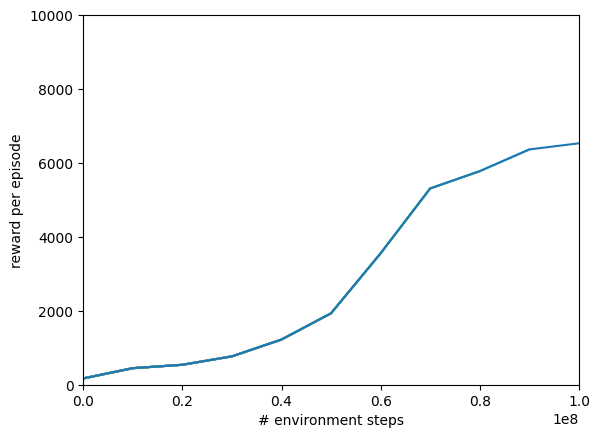

In [3]:
logger = WandbLogger(project_name, config=config)
config['logger'] = logger
    # ================ Progress Function ================
xdata = []
ydata = []
eval_sps = []
train_sps = []
times = [datetime.now()]

def progress(num_steps, metrics, path="../data/ppo", name="ppo_training_plot.png"):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics["eval/episode_reward"].cpu())
    eval_sps.append(metrics["speed/eval_sps"])
    train_sps.append(metrics["speed/sps"])
    plt.xlim([0, config['num_timesteps']])
    plt.ylim([0, 10_000])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.plot(xdata, ydata)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    timestamped_name = f"{timestamp}_{name}"
    PLT_SAVE_PATH = os.path.join(path, timestamped_name)
    plt.savefig(PLT_SAVE_PATH)
# ================ Progress Function ================
agents = train(**config, progress_fn=progress)
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")
print(f"eval steps/sec: {np.mean(eval_sps)}")
print(f"train steps/sec: {np.mean(train_sps)}")



In [5]:
print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")
print(f"eval steps/sec: {np.mean(eval_sps)}")
print(f"train steps/sec: {np.mean(train_sps)}")

time to jit: 0:00:59.487934
time to train: 0:25:53.396792
eval steps/sec: 94858.63458039175
train steps/sec: 67806.00671007622


In [6]:
from Humanoid_MARL.envs.torch_wrapper import TorchWrapper
config = {
        'num_timesteps': 100_000_000,
        'eval_frequency': 10,
        'episode_length': 1000,
        'unroll_length': 10,
        'num_minibatches': 32,
        'num_update_epochs': 8,
        'discounting': 0.97,
        'learning_rate': 3e-4,
        'entropy_cost': 1e-3,
        'num_envs': 2048,
        'batch_size': 512,
        'env_name': "humanoid",
        'render' : False,
        'device' : 'cuda',
        'model_path' : "../models/20240212_214953_ppo_humanoid.pt",
        'video_length' : 300,
    }
env = envs.create(
        config['env_name'], batch_size=None, episode_length=config['episode_length'], backend="generalized"
    )
env = GymWrapper(env, get_jax_state=True)
env = TorchWrapper(env, device=config['device'], get_jax_state=True)


In [7]:

# env warmup
observation = env.reset()
action = torch.zeros(env.action_space.shape[0] * env.num_agents).to(config['device'])
env.step(action)
# agents = load_models(config['model_path'], Agent, device=config['device'])
# agents = [agent.eval() for agent in agents]
print(len(agents))
jax_states = []
num_steps = 1000

eval_reward = 0.0
episodes = torch.zeros((), device = config['device'])
for i in range(num_steps):
    print(f"{i} / {num_steps}")
    logits, action = get_agent_actions(agents, observation, env.obs_dims)
    jax_state, observation, reward, done, info = env.step(Agent.dist_postprocess(action[0]))
    episodes += torch.sum(done)
    jax_states.append(jax_state)
    print(f"{i} | {info} | DONE [{done}] | Reward [{reward}]")
    eval_reward += reward
print(f"Total Reward | {eval_reward / episodes}")

1
0 / 1000
0 | {'distance_from_origin': tensor(0.9374, device='cuda:0'), 'first_obs': tensor([ 1.3964e+00,  9.9022e-01, -5.0478e-03, -4.1752e-03,  8.2115e-03,
        -3.0075e-03, -2.3696e-04,  5.0182e-03, -2.1919e-03,  8.7368e-03,
        -7.9229e-03,  3.3246e-03, -6.0711e-03,  8.0665e-03,  7.3675e-03,
        -9.5078e-03, -1.2503e-03,  8.0097e-03,  5.7708e-03, -1.8930e-03,
         2.9378e-03, -5.4378e-03, -1.0107e-04,  4.8649e-03, -4.7188e-03,
         2.7836e-03,  2.4877e-03,  1.9663e-03, -1.1979e-03, -1.6890e-03,
        -4.4962e-03, -8.0390e-03,  8.2597e-03,  4.6945e-03, -8.8630e-03,
         6.0610e-03, -1.7541e-04, -5.4629e-03, -2.6865e-03,  8.5640e-03,
        -9.5905e-03,  5.7331e-03, -1.2208e-03,  7.3980e-04,  8.2583e-03,
         2.2379e+00,  8.4696e-04,  8.9562e-02,  8.4696e-04,  2.2228e+00,
        -1.3639e-02,  8.9562e-02, -1.3639e-02,  4.5343e-02,  8.9075e+00,
         9.3039e-02,  7.3657e-05,  1.1370e-02,  7.3657e-05,  8.8489e-02,
         1.2817e-04,  1.1370e-02,  1.2

In [9]:
HTML(html.render(env.sys, [jax_state.pipeline_state for jax_state in jax_states])) 

In [10]:
HTML(html.render(env.sys, [jax_state.pipeline_state for jax_state in jax_states])) 

In [ ]:
with torch.no_grad():
                episode_count, episode_reward = eval_unroll(
                    agents, env, config['episode_length'], config['device'], render=None
                )
print(f"Episode {episode_count} reward: {episode_reward}")